@ Author : Hemant Soni

### 1: Introduction
Hard-Margin SVM can be transformed into a standard Quadratic Programing problem. For beginners or researchers focusing on application, it is challenging to implement very detailed numerical optimization method. So, we'll use cvxopt module for optimization.

### 2: Introduction To cvxopt

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from cvxopt import matrix, solvers
solvers.options["show_progress"] = False

#### 2.1 Example For Optimization Problem

Consider the following optimization problem:

Minimize: $f(x, y) = (1/2)*x^2 + 3x + 4y$

Subject to:

* $x, y \geq 0$ (non-negativity constraints)
* $x + 3y \geq 15$
* $2x + 5y \leq 100$
* $3x + 4y \leq 80$

Solve it by cvxopt package, transcribe this problem into a standard QP problem

Cvxopt expect equation in this form below so we have to rewrite above equations in the following format.

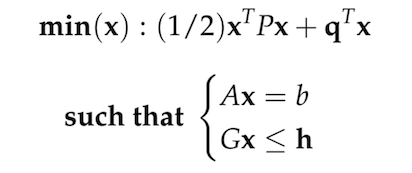

We can rewrite above as:

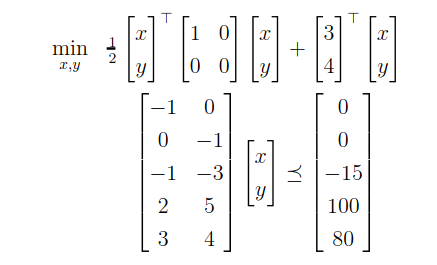


In [ ]:
# initialize variables
P = matrix(np.array([[1, 0], [0, 0]], dtype=np.float64))
q = matrix(np.array([3, 4], dtype=np.float64))
G = matrix(np.array([[-1, 0], [0, -1], [-1, -3], [2, 5], [3, 4]], dtype=np.float64))
h = matrix(np.array([0, 0, -15, 100, 80], dtype=np.float64))
# A and b are not required as there is no equality constraint

In [ ]:
sol = solvers.qp(P, q, G, h)

In [ ]:
print(sol['x'])   # With x = 0 and y = 5 We have optimal solution

[ 7.13e-07]
[ 5.00e+00]



In [ ]:
print("Optimal Value: ", sol['primal objective'])

Optimal Value:  20.00000617311241


### Task 1 :
Consider the following optimization problem:

$$
\begin{align*}
\underset{x_1, x_2}{\text{minimize}} \quad & 2x_1^2 + x_2^2 + x_1 x_2 + x_1 + x_2 \\
\text{subject to} \quad & x_1 \ge 0, \\
& x_2 \ge 0, \\
& x_1 + x_2 = 1.
\end{align*}
$$

Solve it by cvxopt package, transcribe this problem into a standard QP problem

### 3: Hard Margin SVM With QP

##### 3.1: Data Loading

In [ ]:
X, y = make_blobs(n_samples=100, random_state = 1, centers=2, n_features=2)
y[y == 0] = -1
y = y.reshape(-1, 1)*1.  #to float

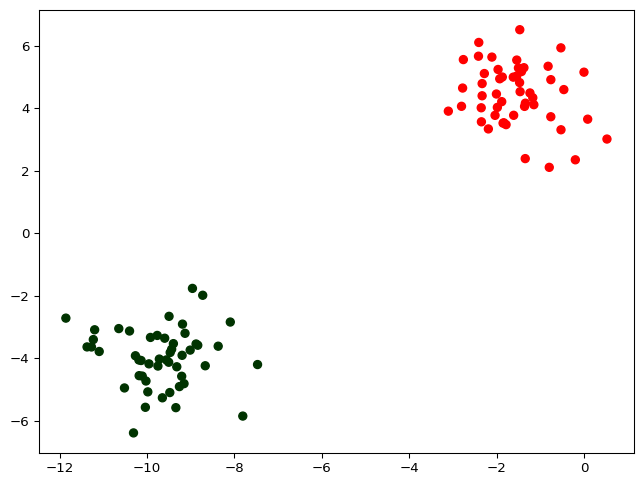

In [ ]:
plt.figure(figsize=(8, 6), dpi=96)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#003300']))

##### 3.2: SVM as Quadratic Programing Problem

In [ ]:
class SVM():
  def __init__(self):
    # Threshold to Decide if its support vector
    self.sp_v_threshold = 1e-8
    self.sp_v_i = []

  def fit(self, X, y):
    m, n = X.shape

    # Define Variables
    H = np.dot((y * X), (y * X).T)
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    h = matrix(np.zeros(m))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(-np.eye(m))

    # Solve For Optimization
    sol = solvers.qp(P, q, G, h, A, b)

    # Calculate weight
    alphas = np.array(sol['x'])
    w = ((y * alphas).T @ X).reshape(-1,1)

    # Calculate bias
    ind = np.where(y == -1)[0]
    p1 = X[ind] @ w
    ind = np.where(y == 1)[0]
    p2 = X[ind] @ w
    b = -(max(p1) + min(p2)) / 2

    self.w = w
    self.b = b

    # Calculate Support Vectors
    for i in range(m):
      v = y[i] * (np.dot(self.w.T, X[i]) + self.b)
      if v <= (1 + self.sp_v_threshold):
          self.sp_v_i.append(i)

    return w, b, self.sp_v_i

  def predict(self, X):
    return np.sign(np.dot(self.w.T, X.T) + self.b)

In [ ]:
model = SVM()
w, b, support_vector_points = model.fit(X,y)

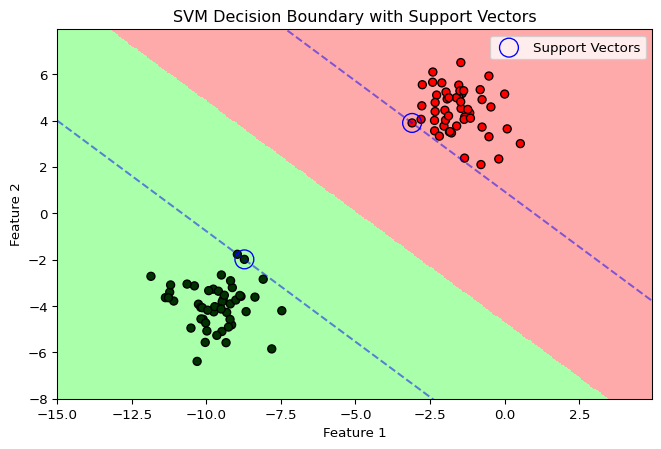

In [ ]:
# Define x_min, x_max, y_min, y_max, and step
x_min, x_max = -15, 5
y_min, y_max = -8, 8
step = 0.05

# Generate meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))
mesh_grid = np.c_[xx.ravel(), yy.ravel()]

# Predict labels for each point in meshgrid
z = model.predict(mesh_grid)
z = z.reshape(xx.shape)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#003300'])

# Plot decision boundary and support vectors
X_sv = X[model.sp_v_i]
plt.figure(figsize=(8, 5), dpi=96)
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors='k')
plt.scatter(X_sv[:, 0], X_sv[:, 1], s=200, edgecolors="b", marker="o", facecolors='none', label="Support Vectors")
for sv in X_sv:
  slope = -model.w[0] / model.w[1]  # Slope of the line
  intercept = sv[1] - slope * sv[0]  # Intercept of the line
  plt.plot([x_min, x_max], [x_min * slope + intercept, x_max * slope + intercept], color='blue', linestyle='--', alpha=0.5)
plt.legend()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVM Decision Boundary with Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
# Parameters of Our Model
print("Model Weights: ", w)
print("Model Bias: ", b)
print("Model Support Vectors: ", X_sv)

Model Weights:  [[-0.16964602]
 [-0.17773322]]
Model Bias:  [-0.8330066]
Model Support Vectors:  [[-3.10367371  3.90202401]
 [-8.72395657 -1.9862468 ]]


### Task 2:
Implement SVC from SKlearn libaray with linear kernal on the same dataset and compare various model parameters from both eg. weight, bias, support vectors.
Evalutate there performance and accuracy.

### Task 3:
For the above code try to work with different datasets and find if there is any issue with the code and its decision boundary.
If there are any try to optimize the following code.
